## Effect of probe duration on THz-TDS detection bandwidth
Trying to model the detection (and ideally generation) of THz using EOS, as is done in "Wideband THz Time Domain Spectroscopy based on Optical Rectification and Electro-Optic Sampling" by Tomasino et al. (2013).

Had a quick chat with Matteo about this. He says it is pretty simple, the paper should explain exactly how it is done.
See fig. 4d; This is something like what we want to get, achieved with the equation above this, eq. 12.

### Lvl 1:
Model detection only. Assume delta probe pulse (so Aopt = 1) and consider X2 as constant. Then assume a probe pulse with duration = 245fs, and with 55fs. Compare and show that finite pulse duration limits the bandwidth.

Eqs to use: 13, 14, 15.

Matteo says the paper should explain exactly how this is done. He says delta k is calculated as written below eq. 15.

### Lvl 2:
Model generation as well, then apply the resulting THz bandwidth to Lvl 1 to get some expected bandwidth for our working condition. Show that this transfers experimentally by comparing with data.

## Important quantities:

omega = 2*pi*f

k = 2*pi / lambda

k = omega / v_phase

v_phase = f*lambda

---

Define equations

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import pandas as pd

def Aopt(omega, pulseDuration):
    return((np.sqrt(np.pi)/pulseDuration)*np.exp(-(omega**2 * pulseDuration**2)/4))

def deltaPhi(Ldet, delta_k):
    return((np.exp(-1j * delta_k * Ldet) - 1)/(1j * delta_k))

def freq_response(Aopt, X2, deltaPhi):
    return(Aopt*X2*deltaPhi)

Define constants

In [319]:
res = int(1e4) # resolution of simulation. NOTE: USE THIS FOR ALL LINSPACES!
c = 299792458 # speed of light in vacuum: m/s
L_det = 300e-6 # detection crystal thickness: 300 um
wvl_probe = 1030e-9 # probe wavelength: 1030 nm
freq_thz = 3e12 # THz frequency: 3 THz

X2 = 0.97e-12 # chi(2) coefficient: pm/V. NOTE: This should be the electro-optic coefficient (I think?)
# In Tomasino et al. they say X2 is the second-order susceptibility for the DFG case (the same as the OR case). Is this the r_41? Or d_41? I... don't know.

Helper functions

In [320]:
# delta k = k_probe(omega_probe) + k(omega_thz) - k_probe(omega_probe - omega_thz)
k = lambda wvl: 2*np.pi / wvl
# omega = 2 * pi * f
omega = lambda freq: 2*np.pi*freq
# lambda = c / f
wvl = lambda freq: c / freq

Try it out with some range of THz frequencies for the case where Aopt = 1

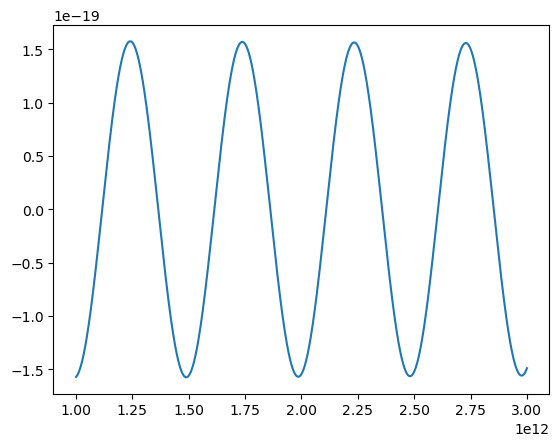

In [321]:
freq = np.linspace(1e12, 3e12, res) # THz frequency range
response = []

for f in freq:
    wvl_thz = wvl(f)
    delta_k = k(wvl_probe) + k(wvl_thz) - k(wvl_probe - wvl_thz)
    response.append(freq_response(1, X2, deltaPhi(L_det, delta_k)))

plt.plot(freq, np.real(response))


Try it out with finite probe duration

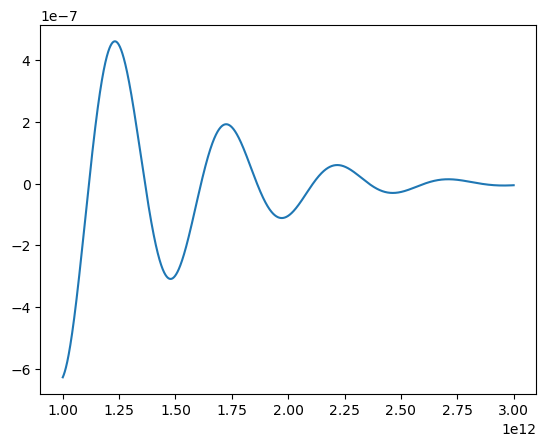

In [322]:
response_long_pulse = []
response_short_pulse = []

t_long = 245e-15
t_short = 55e-15

for f in freq:
    wvl_thz = wvl(f)
    delta_k = k(wvl_probe) + k(wvl_thz) - k(wvl_probe - wvl_thz)
    response_long_pulse.append(freq_response(Aopt(omega(f), t_long), X2, deltaPhi(L_det, delta_k)))
    response_short_pulse.append(freq_response(Aopt(omega(f), t_short), X2, deltaPhi(L_det, delta_k)))

plt.plot(freq, np.real(response_long_pulse))

That's Lvl 1 done. I guess.

---

## Lvl 2: Simulate generation

Define electric field equations.
I am assuming z is the propagation of the beam, we can calculate this from the time of the pulse.

In [323]:
n_thz = np.linspace(3.36,3.39,res) # rough estimates from Hekmat et al.
E0 = 1 # normalise electric field for now
t_pump = 245e-15 # pump pulse duration: 245 fs
n_g = 3.4216 # NOTE: from refractiveindex.info (Parsons and Coleman)
max_time = 7e-12
# max_time = 5e-12
time = np.linspace(0,max_time,res) # 8ps time sample
# v = s/t, so s = v*t
z = c*time # NOTE: this could be another source of error

def E1(n_thz, omega):
    return(E0**2 * X2 * t_pump * np.sqrt(np.pi))/(2*(n_thz**2 - n_g**2)) * np.exp(- (t_pump**2 * omega**2) / 4)

def E2(n_thz, omega, z):
    return(0.5*(1 - n_g/n_thz)*np.exp(1j * n_thz * omega * z / c))

def E3(n_thz, omega, z):
    return(0.5*(1 + n_g/n_thz)*np.exp(-1j * n_thz * omega * z / c))

def E4(omega, z):
    return(np.exp(-1j * n_g * omega * z / c))

def E(n_thz, omega, z):
    return(E1(n_thz, omega)*(E2(n_thz, omega, z) + E3(n_thz, omega, z) - E4(omega, z)))

Create function for n_thz. This is created from fitting Parsons and Coleman data with power function.

In [324]:
power = lambda x, a, b, c: a*(x**b) + c
a = 1346
b = -2.373
c = 3.34

parsons = pd.read_csv('Parsons.csv')
x = np.linspace(min(parsons['wl']), max(parsons['wl']), res)

n_thz = power(x, a, b, c) # this gives us values of n_thz for all points simulated. R-square is 0.9987

Try plotting the electric field for some range of z values.

Text(0, 0.5, 'E field ^2')

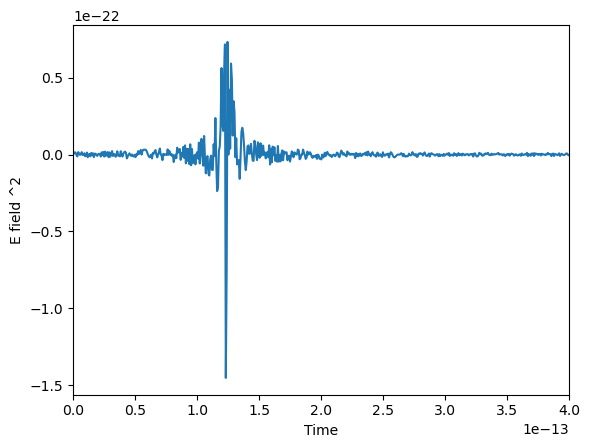

In [329]:
E_field = []
for i, f in enumerate(freq):
    E_field.append(E(n_thz[i], omega(f), z[i]))

plt.plot(time, np.real(E_field))
plt.xlim([0,0.4e-12])
plt.xlabel("Time")
plt.ylabel("E field ^2")

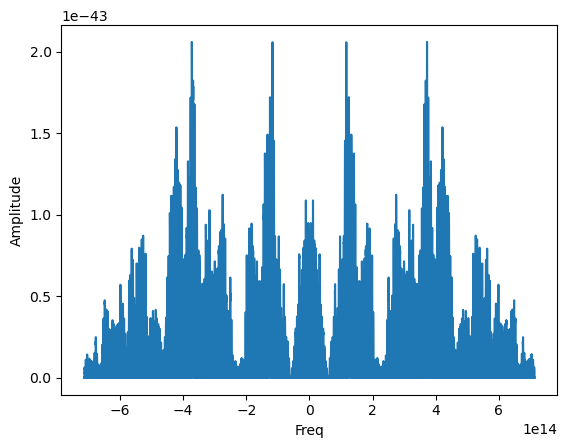

In [328]:
sampleRate = res / max_time

fd = fft.fft(np.real(E_field))
xf = fft.fftfreq(res, 1/sampleRate)

ax = plt.subplot(111)
# ax.set_xlim([0, 2e13])
# ax.set_ylim([0, 0.1e-43])

plt.xlabel("Freq")
plt.ylabel("Amplitude")
plt.plot(xf,np.real(fd)**2)

(0.0, 5e-13)

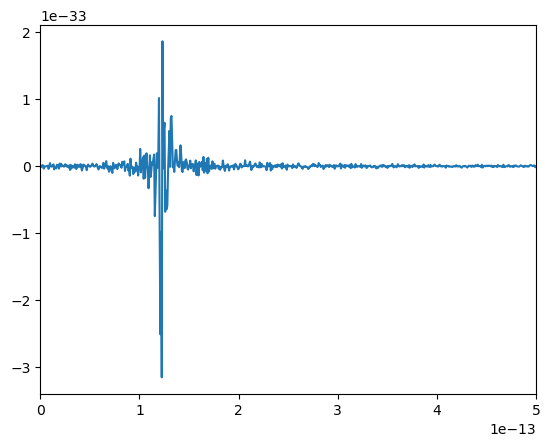

In [331]:
E_det = []

for i, f in enumerate(freq):
    delta_k = k(wvl_probe) + k(wvl(f)) - k(wvl_probe - wvl(f))
    FR = freq_response(Aopt(omega(f), t_short), X2, deltaPhi(L_det, delta_k))
    EF = E(n_thz[i], omega(f), z[i])
    # EF = E(E1(n_thz[i], omega(f)), E2(n_thz[i], omega(f), z[i]), E3(n_thz[i], omega(f), z[i]), E4(omega(f), z[i]))
    E_det.append(FR*EF)

plt.plot(time, np.real(E_det))
plt.xlim(0,0.5e-12)